# Description of the Notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

This notebook presents one solution we propose to the **Homework 1 of the course of Advanced neural networks and deep learning**.

The main network you can find in this notebook is ConvNeXtBase, from keras application.

```
convnext = tfk.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg',
    classifier_activation="softmax",
)
tfk.utils.plot_model(convnext, show_shapes=True)
```



```
# set layers as not trainable
convnext.trainable = False

# Create an input layer with shape (96, 06, 3)
input = tfk.Input(shape=(96, 96, 3))

# preprocess data
preprocessing = tf.keras.applications.convnext.preprocess_input(input)

# augment
augmentation = tf.keras.Sequential([
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
    ], name='preprocessing')
#augment = augmentation(preprocessing)

# Connect ConvNeXtBase to the input
x = convnext(preprocessing)
x = tfkl.Dropout(0.3) (x)

# regularization
l2_lambda = 5e-7
x = tfkl.Dense(1024, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)) (x)
x = tfkl.Dense(1024, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)) (x)
x = tfkl.Dropout(0.3) (x)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='output_layer')(x)
```





This network has been trained with a 85-15 % division between training and validation set.

The dataset has been cleaned from the obvious outliers present before the splitting, and an additional weight balancing has been added, in order to manage the unbalanced dataset.

Lastly, the model has been fine tuned.


### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Colab Notebooks/promising(?)

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/promising(?)


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 38

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
from numpy import load

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load and process the dataset

In [5]:
#load data
data = load('../public_data.npz', allow_pickle=True)
lst = data.files

In [6]:
#Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']

# Data cleaning

## Shrek

In [7]:
# Select the reference image 'shrek' from the image set
shrek = img_set[58]

# list of images to remove
indexes_to_remove = []
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [8]:
print("Length before removing Shrek: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


## Trololo

In [9]:
# Select the reference image 'trololo' from the image set
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'

# list of images to remove
indexes_to_remove = []
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [10]:
print("Length before removing Trololo: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Training and validation set

## Convert to categorical:
- healthy -> [1 0]
- unhealthy -> [0 1]

In [11]:
# Define a mapping from label strings to numerical values
labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

# Replace label strings with numerical values
for i in range(0, len(label_set)):
    label_set[i] = labels_string_to_num[label_set[i]]

# Expand the label_set dimensions
label_num = np.expand_dims(label_set, axis=-1)

print("Shape of numeric labels: ", label_num.shape)

# Convert numerical labels to one-hot encoded categorical labels
label_cat = tfk.utils.to_categorical(label_num, num_classes=2)

# Print the one-hot encoded label for the first data point
print("Example of categorical label (healthy) after conversion: ", label_cat[0])

Shape of numeric labels:  (5004, 1)
Example of categorical label (healthy) after conversion:  [1. 0.]


## Split train-val

In [12]:
# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(img_set, label_cat, random_state=seed, test_size=.15, stratify=np.argmax(label_cat, axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4253, 96, 96, 3), y_train shape: (4253, 2)
X_val shape: (751, 96, 96, 3), y_val shape: (751, 2)


## Save train-val sets

In [13]:
np.save(file='training_data', arr=X_train, allow_pickle=True)
np.save(file='val_data', arr=X_val, allow_pickle=True)
np.save(file='training_labels', arr=y_train, allow_pickle=True)
np.save(file='val_labels', arr=y_val, allow_pickle=True)

# Weight balancing

In [14]:
# compute the number of components of each category
num_healthy = sum(y == [1, 0] for y in y_train)[0]
num_unhealthy = len(y_train) - num_healthy

print(f"There are {num_healthy} healthy and {num_unhealthy} unhealthy")

# Calculate the total number of samples
total = num_healthy + num_unhealthy

# Calculate class weights for binary classification
# Class weight for 0 (healthy) is calculated based on the imbalance in the dataset
# Weight for class 0 is scaled to help keep the loss to a similar magnitude, ensuring that the sum of weights stays the same.
weight_for_0 = (1 / num_healthy) * (total / 2.0)
# Class weight for 1 (unhealthy) is similarly calculated, maintaining the same total weight.
weight_for_1 = (1 / num_unhealthy) * (total / 2.0)

# Create a dictionary that maps class labels to their corresponding class weights
class_weight = {0: weight_for_0, 1: weight_for_1}

# Print the calculated class weights for class 0 and class 1
print('Weight for class 0 (healthy): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (unhealthy): {:.2f}'.format(weight_for_1))

There are 2636 healthy and 1617 unhealthy
Weight for class 0 (healthy): 0.81
Weight for class 1 (unhealthy): 1.32


# Transfer Learning

## Load train-val sets

In [15]:
X_train = load('training_data.npy', allow_pickle=True)
y_train = load('training_labels.npy', allow_pickle=True)
print('Train:')
print(X_train.shape)
print(y_train.shape)

X_val = load('val_data.npy', allow_pickle=True)
y_val = load('val_labels.npy', allow_pickle=True)
print('Validation')
print(X_val.shape)
print(y_val.shape)

Train:
(4253, 96, 96, 3)
(4253, 2)
Validation
(751, 96, 96, 3)
(751, 2)


## Build model

In [16]:
# Build ConvNeXtBase model
convnext = tfk.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg',
    classifier_activation="softmax",
)
tfk.utils.plot_model(convnext, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
convnext.trainable = False

# Create an input layer with shape (96, 96, 3)
input = tfk.Input(shape=(96, 96, 3))

# preprocess data
preprocessing = tf.keras.applications.convnext.preprocess_input(input)

# augment
augmentation = tf.keras.Sequential([
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
    ], name='preprocessing')
augment = augmentation(preprocessing)

# Connect ConvNeXtBase to the input
x = convnext(augment)

x = tfkl.Dropout(0.3) (x) # regularize
l2_lambda = 5e-7          # regularize

# The weights are initialized to HeUniform
x = tfkl.Dense(1024, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)) (x)
x = tfkl.Dense(1024, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)) (x)
x = tfkl.Dropout(0.3) (x) # regularize

# Add a Dense layer with 2 units and softmax activation as the classifier, and weight initialized to GlorotUniform
outputs = tfkl.Dense(2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='output_layer')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=input, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [18]:
# create callback, will be used later in fine tuning (for best epoch)
tl_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)

In [19]:
# Train the model
tl_history = tl_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [tl_callback],
    class_weight=class_weight
).history

Epoch 1/200
266/266 [==============================] - 71s 154ms/step - loss: 0.8082 - accuracy: 0.6480 - val_loss: 0.6241 - val_accuracy: 0.7377
Epoch 2/200
266/266 [==============================] - 28s 104ms/step - loss: 0.6140 - accuracy: 0.7162 - val_loss: 0.3714 - val_accuracy: 0.8375
Epoch 3/200
266/266 [==============================] - 28s 104ms/step - loss: 0.5436 - accuracy: 0.7378 - val_loss: 0.4027 - val_accuracy: 0.8043
Epoch 4/200
266/266 [==============================] - 26s 99ms/step - loss: 0.4847 - accuracy: 0.7771 - val_loss: 0.3886 - val_accuracy: 0.8162
Epoch 5/200
266/266 [==============================] - 27s 102ms/step - loss: 0.4736 - accuracy: 0.7802 - val_loss: 0.3586 - val_accuracy: 0.8375
Epoch 6/200
266/266 [==============================] - 26s 97ms/step - loss: 0.4764 - accuracy: 0.7773 - val_loss: 0.3484 - val_accuracy: 0.8362
Epoch 7/200
266/266 [==============================] - 29s 108ms/step - loss: 0.4604 - accuracy: 0.7823 - val_loss: 0.3368 - v

## Display results

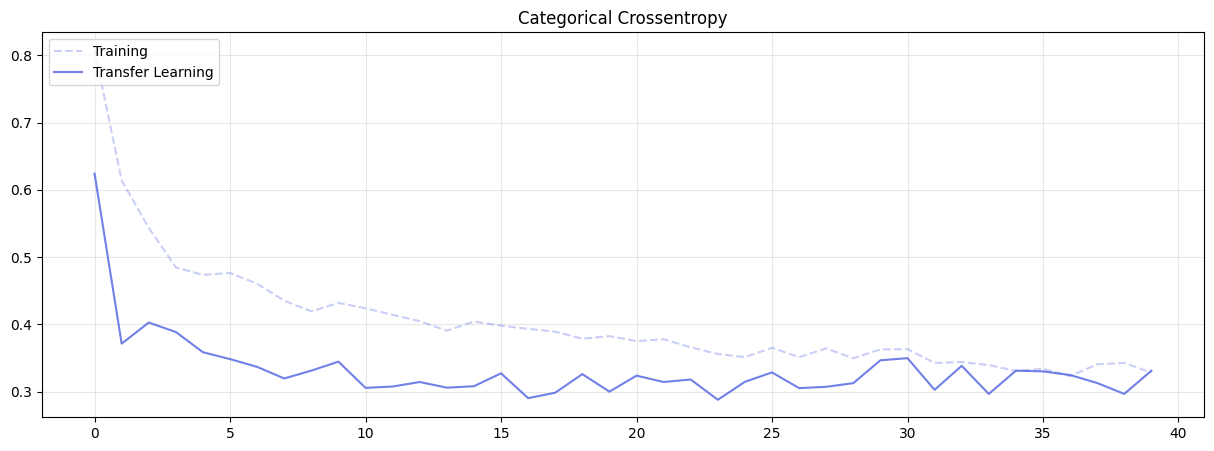

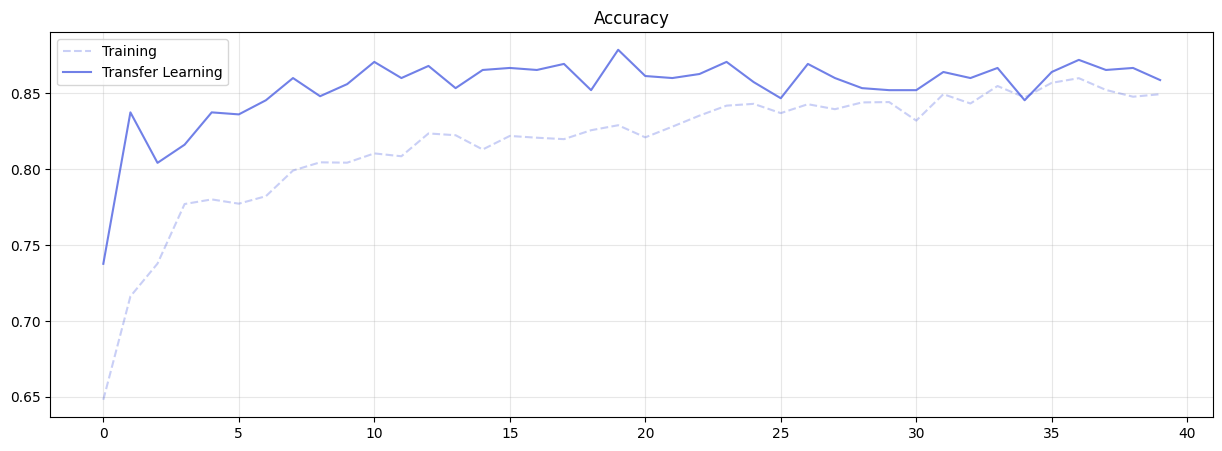

In [20]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Save model

In [21]:
# Save the best model
tl_model.save('tl_ConvNextBaseDropWeightL2')
del tl_model

# Fine Tuning



## Load train-val sets

In [22]:
X_train = load('training_data.npy', allow_pickle=True)
y_train = load('training_labels.npy', allow_pickle=True)
print('Train:')
print(X_train.shape)
print(y_train.shape)

X_val = load('val_data.npy', allow_pickle=True)
y_val = load('val_labels.npy', allow_pickle=True)
print('Validation')
print(X_val.shape)
print(y_val.shape)

Train:
(4253, 96, 96, 3)
(4253, 2)
Validation
(751, 96, 96, 3)
(751, 2)


## Build model

In [23]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('tl_ConvNextBaseDropWeightL2')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [24]:
# Set all ConvNeXtBase layers as trainable
ft_model.get_layer('convnext_base').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
22 co

In [25]:
# define fine tuning callback
ft_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [26]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=5e-5, weight_decay=5e-5), metrics='accuracy')

In [27]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [ft_callback],
    initial_epoch=tl_callback.best_epoch, # from transfer learning callback
    class_weight=class_weight
).history

Epoch 20/200
266/266 [==============================] - 164s 322ms/step - loss: 0.3740 - accuracy: 0.8354 - val_loss: 0.2394 - val_accuracy: 0.9055
Epoch 21/200
266/266 [==============================] - 69s 260ms/step - loss: 0.2674 - accuracy: 0.8853 - val_loss: 0.2193 - val_accuracy: 0.9201
Epoch 22/200
266/266 [==============================] - 66s 249ms/step - loss: 0.2130 - accuracy: 0.9172 - val_loss: 0.2683 - val_accuracy: 0.8948
Epoch 23/200
266/266 [==============================] - 68s 257ms/step - loss: 0.1881 - accuracy: 0.9264 - val_loss: 0.2563 - val_accuracy: 0.9081
Epoch 24/200
266/266 [==============================] - 67s 250ms/step - loss: 0.1853 - accuracy: 0.9306 - val_loss: 0.2147 - val_accuracy: 0.9214
Epoch 25/200
266/266 [==============================] - 67s 254ms/step - loss: 0.1632 - accuracy: 0.9325 - val_loss: 0.1839 - val_accuracy: 0.9281
Epoch 26/200
266/266 [==============================] - 68s 255ms/step - loss: 0.1457 - accuracy: 0.9447 - val_loss: 

## Plot results

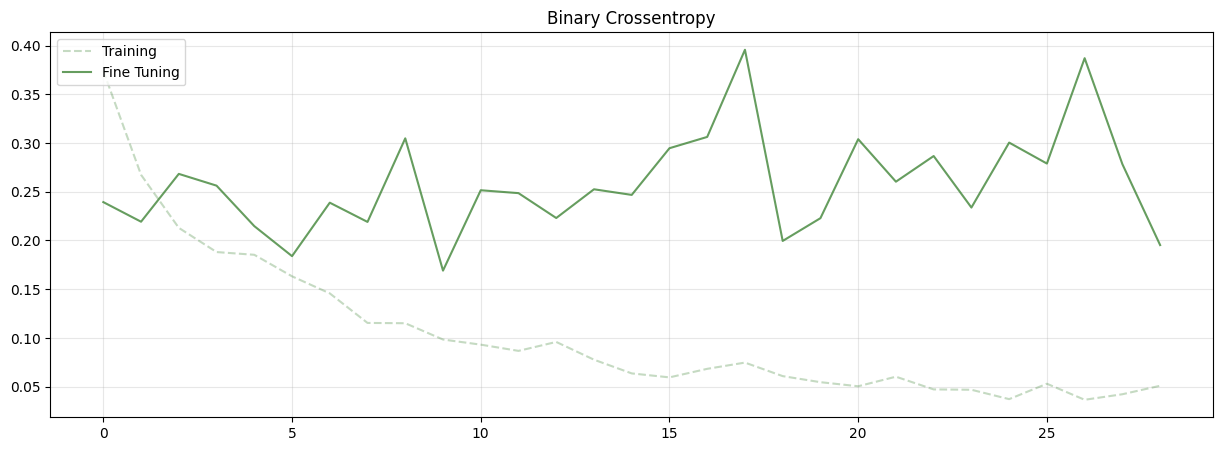

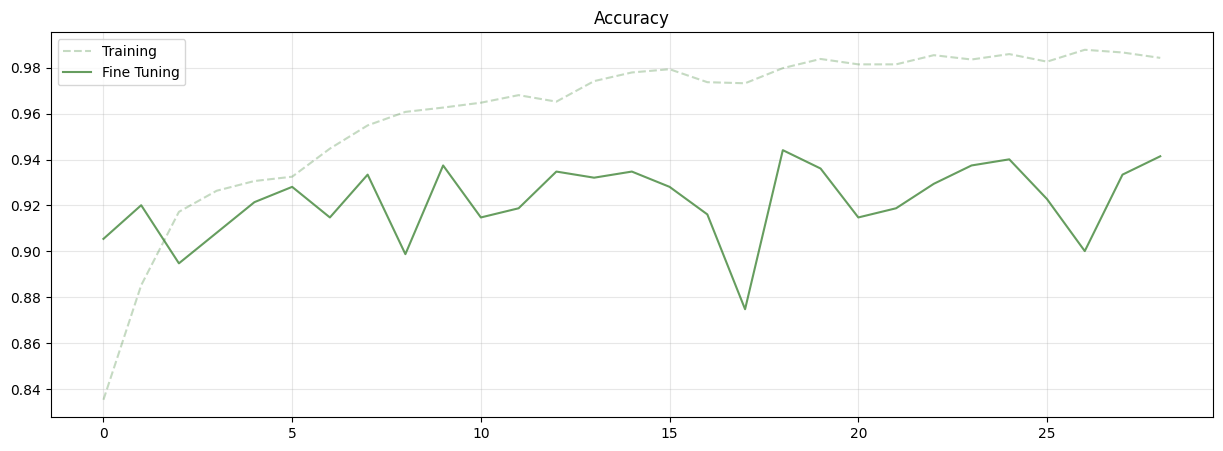

In [28]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
#plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
#plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], label='Training', alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
#lt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
#plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], label='Training', alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Save the model

In [29]:
# Save the best model
ft_model.save('ft_ConvNextBaseDropWeightL2')
del ft_model